In [1]:
pip install torch transformers datasets scikit-learn matplotlib seaborn wordcloud nltk optuna


Note: you may need to restart the kernel to use updated packages.


# Load Dataset

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('spam.csv')  

# Check the first few rows of the dataset
df.head()


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


### CHeck shape of dataset

In [3]:
print(f"The number of rows in a dataset {df.shape[0]}")
print(f"The number of columns in a dataset {df.shape[1]}")

The number of rows in a dataset 5171
The number of columns in a dataset 4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5171.0,2585.000000,1492.883452,0.0,1292.5,2585.0,3877.5,5170.0
label_num,5171.0,0.289886,0.453753,0.0,0.0,0.0,1.0,1.0


## Check the missisng data

In [6]:
# Check for missing values
df.isnull().sum()


Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [7]:
# Check the duplicated values 
print(f"Duplicated values in a dataset: {df.duplicated().sum()}")

Duplicated values in a dataset: 0


### Check Distribution of Labels


/tmp/ipykernel_102647/3285925234.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette="Set3")


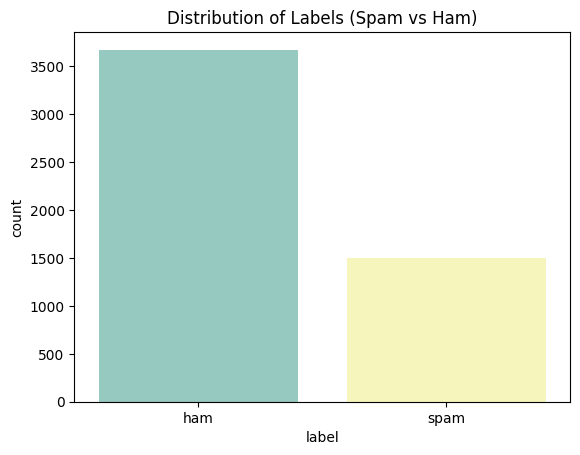

Number of ham(non-spam) emails: 3672
Number of spam emails: 1499


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of labels (spam vs ham)
sns.countplot(x='label', data=df, palette="Set3")

# Get the counts for ham and spam
ham_count = df[df['label'] == 'ham'].shape[0]
spam_count = df[df['label'] == 'spam'].shape[0]

# Set the title
plt.title('Distribution of Labels (Spam vs Ham)')

plt.show()

# Print the counts after the plot
print(f"Number of ham(non-spam) emails: {ham_count}")
print(f"Number of spam emails: {spam_count}")

Obersvation:
THe dataset is imbalance! where one class might dominate to the other! and potentially affecting the models performance.

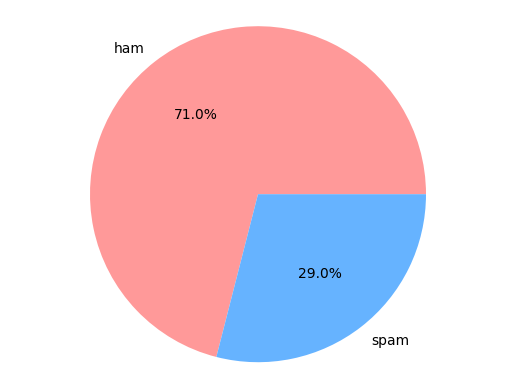

In [9]:
# lets check through pie chart
labels = df['label'].value_counts().index
sizes = df['label'].value_counts().values
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700']  # Define custom colors

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')  # Ensures the pie chart is a circle
plt.show()

### Text Length Analysis

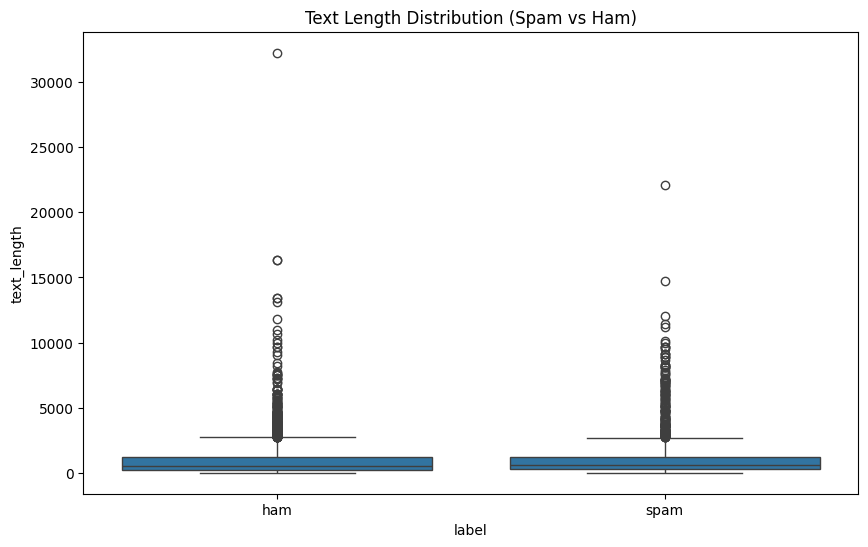

label
ham      977.008170
spam    1223.256171
Name: text_length, dtype: float64

In [10]:
# Add a new column for text length
df['text_length'] = df['text'].apply(len)

# Plot the text length distribution for spam vs ham
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Text Length Distribution (Spam vs Ham)')
plt.show()

# Calculate average text length for each class
df.groupby('label')['text_length'].mean()


### World Cloud for SPam and Ham EMails

In [11]:
df.head()

,Unnamed: 0,label,text,label_num,text_length
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,327
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,414
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,336


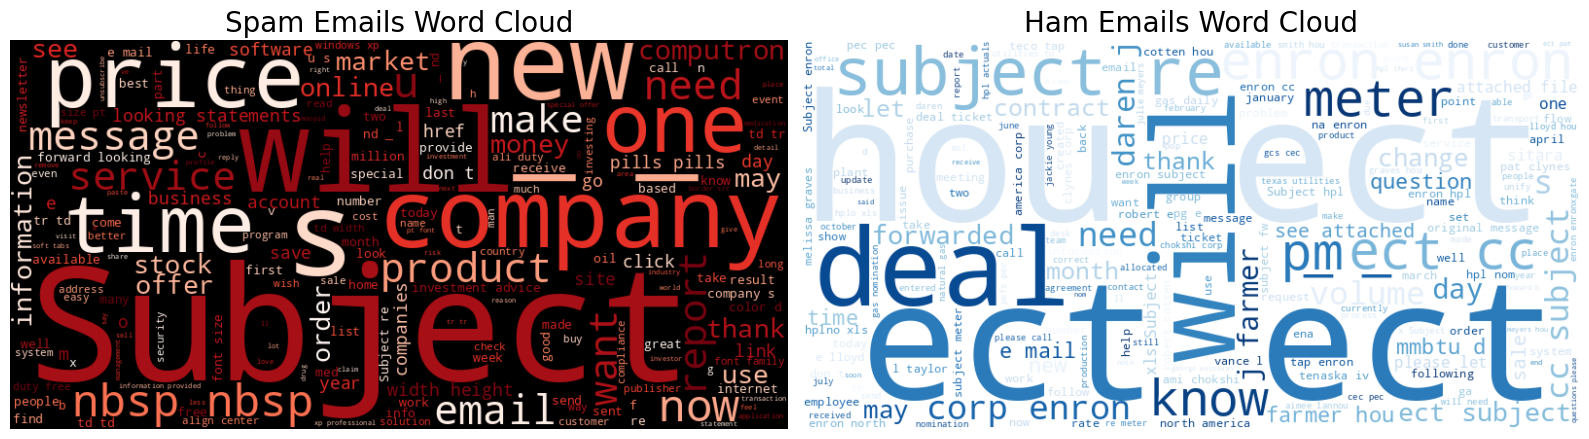

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure no missing values in the 'text' column
df['text'] = df['text'].fillna('')

# Separate spam and ham emails
spam_emails = df[df['label'] == 'spam']
ham_emails = df[df['label'] == 'ham']

# Combine all text for spam and ham emails
spam_text = " ".join(text for text in spam_emails['text'] if text.strip())
ham_text = " ".join(text for text in ham_emails['text'] if text.strip())

# Check if text exists for each category
if not spam_text.strip():
    print("No spam emails found!")
else:
    spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(spam_text)

if not ham_text.strip():
    print("No ham emails found!")
else:
    ham_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(ham_text)

# Plot the word clouds
plt.figure(figsize=(16, 8))

if spam_text.strip():
    plt.subplot(1, 2, 1)
    plt.imshow(spam_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Spam Emails Word Cloud', fontsize=20)

if ham_text.strip():
    plt.subplot(1, 2, 2)
    plt.imshow(ham_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Ham Emails Word Cloud', fontsize=20)

plt.tight_layout()
plt.show()


### Text Preprocessing

In [13]:
import re
from nltk.corpus import stopwords

# Ensure that NLTK stopwords are downloaded
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply the preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/darklight/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
df.head()

,Unnamed: 0,label,text,label_num,text_length,cleaned_text
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,327,subject enron methanol meter follow note gave ...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97,subject hpl nom january see attached file hpln...
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524,subject neon retreat ho ho ho around wonderful...
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,414,subject photoshop windows office cheap main tr...
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,336,subject indian springs deal book teco pvr reve...


## Save the Cleaned Dataset

In [15]:
# Save the cleaned dataset to a CSV file
cleaned_dataset_path = 'cleaned_spam.csv'
df.to_csv(cleaned_dataset_path, index=False)
print(f"Cleaned dataset saved to {cleaned_dataset_path}")


Cleaned dataset saved to cleaned_spam.csv
